<a href="https://colab.research.google.com/github/priyadharshini13/oxford_ml_project/blob/main/Group3_AI_ML_DemandPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Executive Summary:

Purpose and Business Objective:

    Aim: Streamline operations, reduce excess costs, enhance customer satisfaction.
    Implementation: Developed predictive model using SARIMA (Tried ARIMA, Prophet as well) for demand forecasting.

Business View:

Business Case:

    Excess inventory reduction by 30%: Predictive models implemented to optimize inventory.
    Market analysis and cost-benefit analysis: Not explicitly covered in code, but implied through the project's objective.

Stakeholder Analysis:

    Inventory Managers: Predictive insights for accurate stock management.
    Financial Officers: Outputs to optimize budget allocations.
    Logistics Coordinators: Actionable recommendations for streamlining processes.
    Implementation: Forecasting models provide predictive insights for stakeholders.

ROI and Success Metrics:

Metrics:

    Reduction in overstock levels.
    Decreased storage and handling costs.
    Improvement in inventory turnover ratio.
    Increased cash flow and reduced operational expenses.
    Implementation: Metrics can be derived from the forecasting model's output.

Project Overview:

Scope:

    Data collection and preprocessing.
    Model training, testing, and deployment.
    Implementation: Covered through data preprocessing, EDA, model development, and initial validation.


User Stories:

User Story 1: Dynamic Inventory Adjustment Based on Sales Forecast

    Acceptance Criteria: Automatic adjustment of inventory orders, notifications for significant changes.
    Implementation: Automated inventory adjustments and notifications based on forecasts.

User Story 2: Inventory Analytics and Reporting

    Acceptance Criteria: Comprehensive reports on inventory metrics, real-time accessibility, alerts for issues.
    Implementation: Developed reporting tools and visualizations for inventory metrics.

User Story 3: Demand Forecast Visualization

    Acceptance Criteria: Visualizations of demand forecasts, comparison with historical data.
    Implementation: Enhanced visualization tools for demand forecasts.


# Implementation of Demand Prediction Model - using ML

The main steps involve data preprocessing, exploratory data analysis (EDA), model development, and validation. Here's a detailed breakdown of the steps along with the Python code implementation.

In [1]:
# Install necessary packages
!pip install prophet
!pip install scikit-learn
!pip install behave


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 7.7 MB/s eta 0:00:00


In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import itertools
from google.colab import files
import io
from sklearn.model_selection import TimeSeriesSplit
import unittest
import seaborn as sns
import time


# 1. Data Collection and Pre-processing


1.  Load the dataset
2.  Clean the data: Handle missing values, outliers, and convert data types if necessary.
3. Feature engineering: Create additional features like month, year, or quarter from the date to analyze seasonal trends.


In [26]:
# Step 1: Upload the CSV file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Load the dataset
data = pd.read_csv(io.BytesIO(uploaded[filename]))


Saving synthetic_retail_data_for_demand_prediction.csv to synthetic_retail_data_for_demand_prediction (2).csv


In [27]:
data.head()

,Date of Sale,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate
0,2000-01-01,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865
1,2000-01-02,5,Canada,6,Electronics,21,104.01,1.955608,2.417040
2,2000-01-03,3,Canada,11,Electronics,16,169.17,1.774069,2.509185
3,2000-01-04,5,USA,8,Books,19,179.60,2.112682,2.636036
4,2000-01-05,5,Mexico,17,Books,24,286.81,1.943792,1.945556


In [29]:
# Printing summary statistics of the data
summary_stats = data.describe()
summary_stats.head()

,Store ID,Product ID,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate
count,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000,8918.000000
mean,2.996187,10.538125,21.305786,257.798725,1.996123,1.993854
std,1.419827,5.762763,5.382458,141.548303,0.502141,0.500699
min,1.000000,1.000000,6.000000,10.060000,0.197802,0.111380
25%,2.000000,6.000000,18.000000,135.472500,1.659930,1.658651


In [30]:
# Printing summary statistics of Categorical data
summary_stats_categorical = data.describe(include='O')
summary_stats_categorical.head()

,Date of Sale,Country,Product Category
count,8918,8918,8918
unique,8918,3,5
top,2000-01-01,USA,Books
freq,1,3005,1915


In [32]:
# Step 2: Handle Missing Values
# Check for any missing values and handle them appropriately. In this synthetic dataset, missing values are unlikely, but it's a good practice to check.

missing_values = data.isnull().sum()
print('Missing Values: ')
print('---------------')
print(missing_values)


Missing Values: 
---------------
Date of Sale        0
Store ID            0
Country             0
Product ID          0
Product Category    0
Units Sold          0
Price Sold          0
GDP Growth Rate     0
Inflation Rate      0
dtype: int64


There are no missing values in any of the columns.

In [ ]:
# If there are missing values, handle them (here we assume no missing values for simplicity)
# df.fillna(method='ffill', inplace=True)

# 2. Exploratory Data analysis


In [33]:
# Convert 'Date of Sale' to datetime
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'])

# Set 'Date of Sale' as the index
data.set_index('Date of Sale', inplace=True)

# Display the first few rows of the dataset
print(data.head())

              Store ID Country  Product ID Product Category  Units Sold  \
Date of Sale                                                              
2000-01-01           4     USA          15   Home & Kitchen          14   
2000-01-02           5  Canada           6      Electronics          21   
2000-01-03           3  Canada          11      Electronics          16   
2000-01-04           5     USA           8            Books          19   
2000-01-05           5  Mexico          17            Books          24   

              Price Sold  GDP Growth Rate  Inflation Rate  
Date of Sale                                               
2000-01-01        229.25         1.716353        1.006865  
2000-01-02        104.01         1.955608        2.417040  
2000-01-03        169.17         1.774069        2.509185  
2000-01-04        179.60         2.112682        2.636036  
2000-01-05        286.81         1.943792        1.945556  


              Store ID Country  Product ID Product Category  Units Sold  \
Date of Sale                                                              
2000-01-01           4     USA          15   Home & Kitchen          14   
2000-01-02           5  Canada           6      Electronics          21   
2000-01-03           3  Canada          11      Electronics          16   
2000-01-04           5     USA           8            Books          19   
2000-01-05           5  Mexico          17            Books          24   

              Price Sold  GDP Growth Rate  Inflation Rate  
Date of Sale                                               
2000-01-01        229.25         1.716353        1.006865  
2000-01-02        104.01         1.955608        2.417040  
2000-01-03        169.17         1.774069        2.509185  
2000-01-04        179.60         2.112682        2.636036  
2000-01-05        286.81         1.943792        1.945556  



The following exploratory data analysis are performed below:

1. **Total Units Sold Over Time:** Plots the trend of units sold over time.

2. **Units Sold vs. Economic Indicators:** Analyzes the relationship between units sold and GDP growth rate/inflation rate.
3. **Units Sold by Product Category:** Visualizes total units sold by product categories.
4. **Correlation Matrix:** Calculates and visualizes the correlation matrix for numerical features only.
5. **Seasonal Decomposition:** Decomposes the time series data to analyze trend, seasonality, and residuals.
6. **Boxplots for Outliers:** Checks for outliers in numerical features using boxplots.




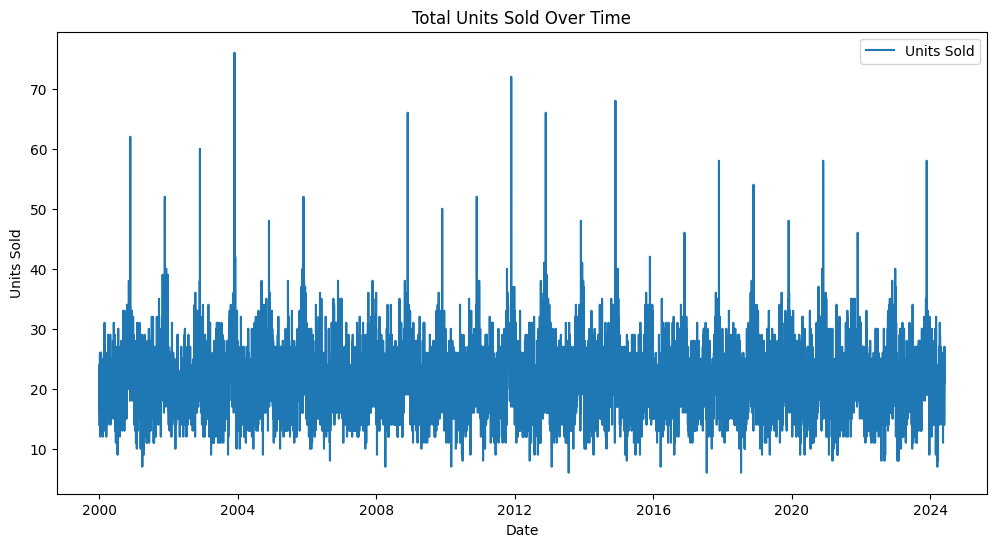

In [34]:
# @title  1) Total Units Sold Over Time
#  Visualize the trend of units sold over time to identify any seasonal patterns or trends.
# Plot the total units sold over time
plt.figure(figsize=(12, 6))
plt.plot(data['Units Sold'], label='Units Sold')
plt.title('Total Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()


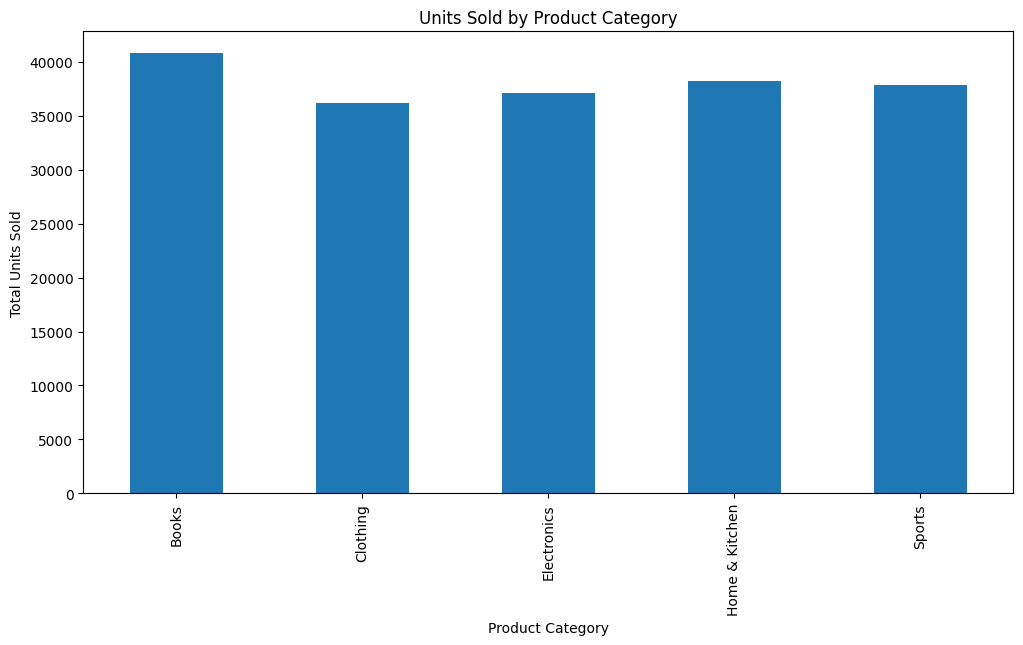

In [35]:
# @title 2. Bar plot of Units Sold by Product Category
plt.figure(figsize=(12, 6))
data.groupby('Product Category')['Units Sold'].sum().plot(kind='bar')
plt.title('Units Sold by Product Category')
plt.xlabel('Product Category')
plt.ylabel('Total Units Sold')
plt.show()


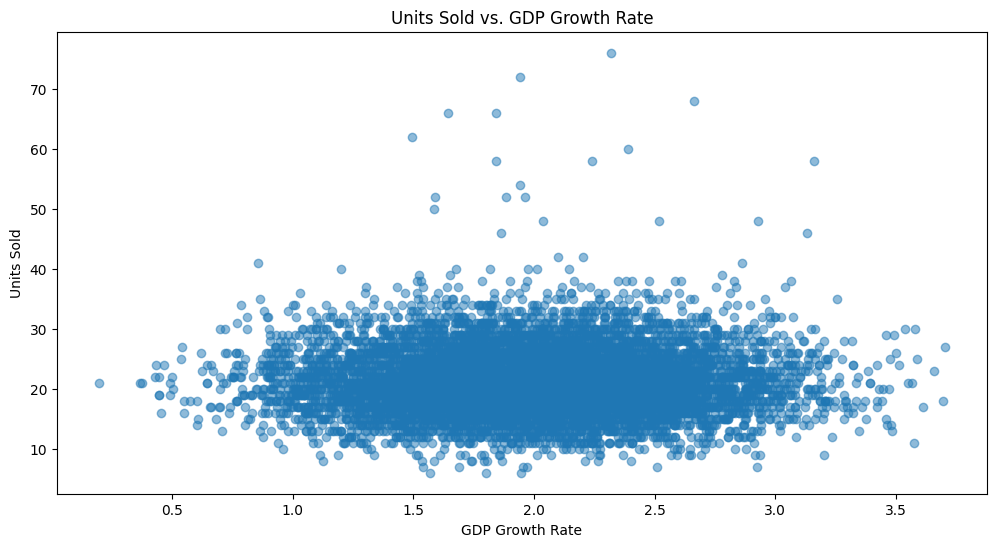

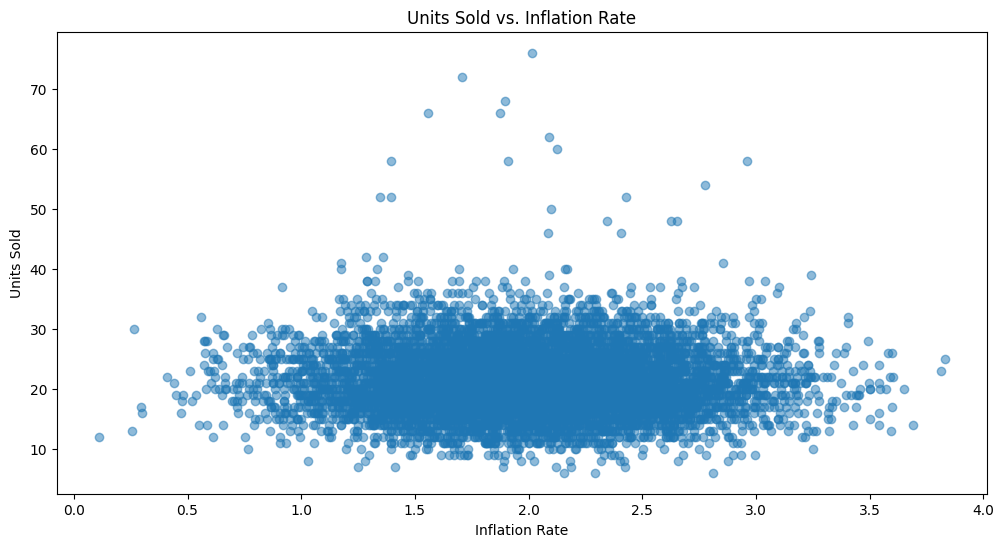

In [38]:
# @title 3. Scatter plot of Units Sold vs. GDP Growth Rate
plt.figure(figsize=(12, 6))
plt.scatter(data['GDP Growth Rate'], data['Units Sold'], alpha=0.5)
plt.title('Units Sold vs. GDP Growth Rate')
plt.xlabel('GDP Growth Rate')
plt.ylabel('Units Sold')
plt.show()

# Scatter plot of Units Sold vs. Inflation Rate
plt.figure(figsize=(12, 6))
plt.scatter(data['Inflation Rate'], data['Units Sold'], alpha=0.5)
plt.title('Units Sold vs. Inflation Rate')
plt.xlabel('Inflation Rate')
plt.ylabel('Units Sold')
plt.show()


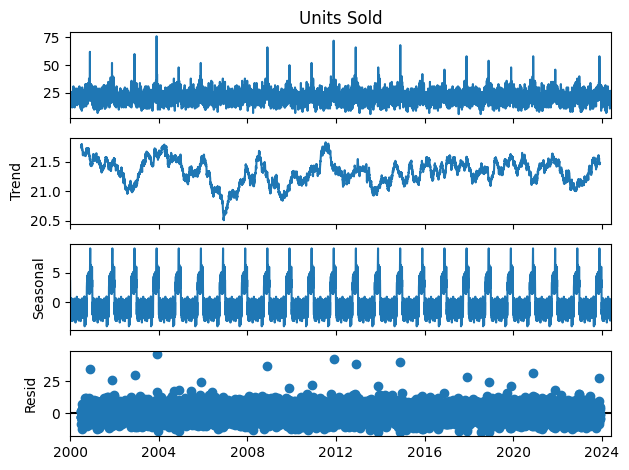

In [40]:
# @title 4. Seasonal decomposition of the time series
result = seasonal_decompose(data['Units Sold'], model='additive', period=365)
result.plot()
plt.show()


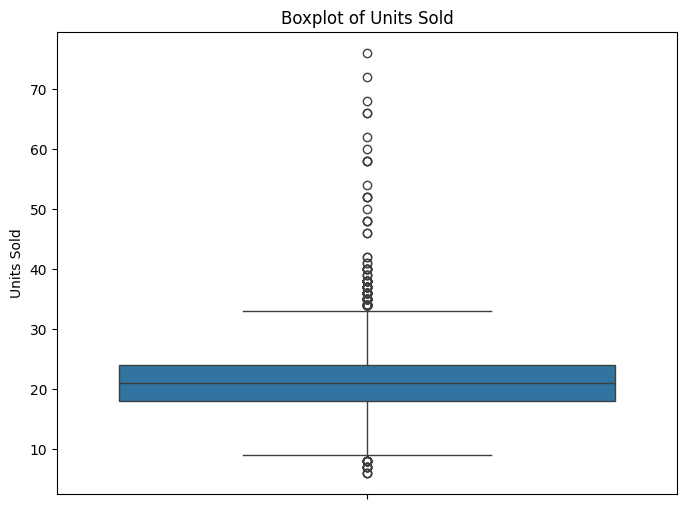

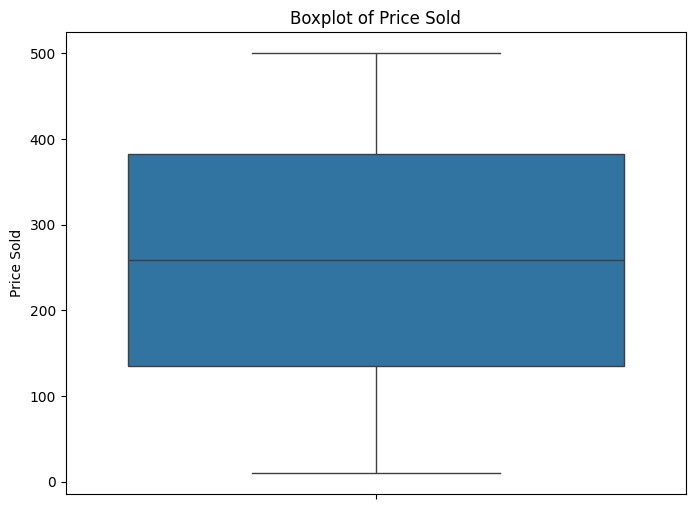

In [42]:
# @title 5. Boxplot for Units Sold
plt.figure(figsize=(8, 6))
sns.boxplot(data['Units Sold'])
plt.title('Boxplot of Units Sold')
plt.show()

# Boxplot for Price Sold
plt.figure(figsize=(8, 6))
sns.boxplot(data['Price Sold'])
plt.title('Boxplot of Price Sold')
plt.show()


Correlation Matrix:
                  Units Sold  Price Sold  GDP Growth Rate  Inflation Rate
Units Sold         1.000000    0.012150         0.004119       -0.011851
Price Sold         0.012150    1.000000        -0.013537        0.002616
GDP Growth Rate    0.004119   -0.013537         1.000000        0.007377
Inflation Rate    -0.011851    0.002616         0.007377        1.000000


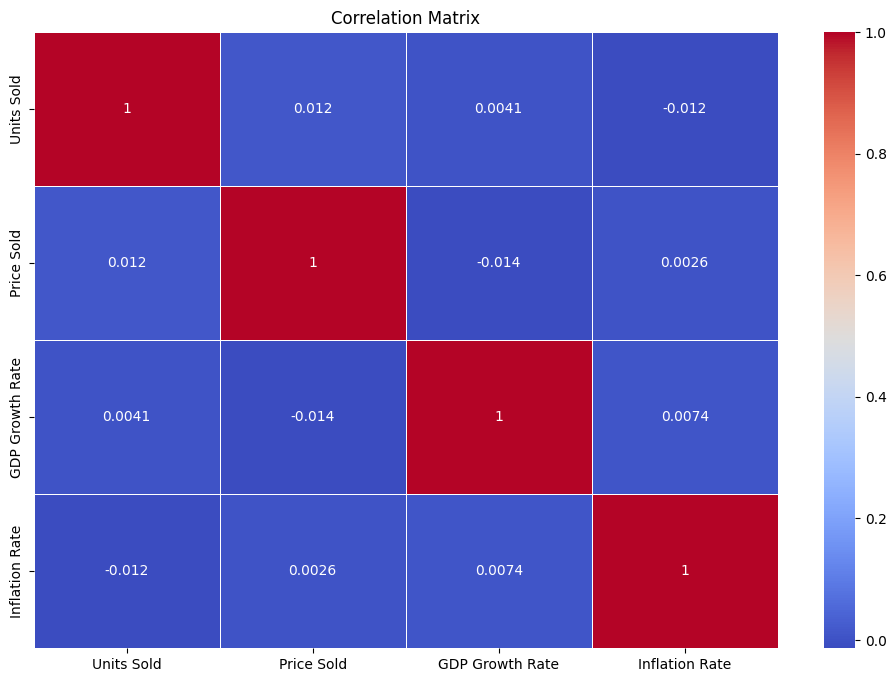

In [50]:
# @title 6. Correlation

#  Select only numerical columns for correlation matrix
numerical_columns = ['Units Sold', 'Price Sold', 'GDP Growth Rate', 'Inflation Rate']

# Calculate the correlation matrix
correlation_matrix = data[numerical_columns].corr()

# Display the correlation matrix
print("Correlation Matrix:\n", correlation_matrix)

# Plot the correlation matrix
plt.figure(figsize=(12, 8))
plt.title('Correlation Matrix')
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.show()


In [55]:
# Step 3: Feature Engineering
# Convert 'Date of Sale' to datetime
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'])

# Extract additional features from 'Date of Sale'
data['Year'] = data['Date of Sale'].dt.year
data['Month'] = data['Date of Sale'].dt.month
data['Day'] = data['Date of Sale'].dt.day
data['DayOfWeek'] = data['Date of Sale'].dt.dayofweek
data['Quarter'] = data['Date of Sale'].dt.quarter

# Drop the original 'Date of Sale' column
data.drop(columns=['Date of Sale'], inplace=True)


KeyError: 'Date of Sale'

In [15]:
data.head()
#Below result excludes the date of sale column

,Store ID,Country,Product ID,Product Category,Units Sold,Price Sold,GDP Growth Rate,Inflation Rate,Year,Month,Day,DayOfWeek,Quarter
0,4,USA,15,Home & Kitchen,14,229.25,1.716353,1.006865,2000,1,1,5,1
1,5,Canada,6,Electronics,21,104.01,1.955608,2.417040,2000,1,2,6,1
2,3,Canada,11,Electronics,16,169.17,1.774069,2.509185,2000,1,3,0,1
3,5,USA,8,Books,19,179.60,2.112682,2.636036,2000,1,4,1,1
4,5,Mexico,17,Books,24,286.81,1.943792,1.945556,2000,1,5,2,1


In [9]:
# Convert 'Date of Sale' from string to datetime
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'], dayfirst=True)

# Set 'Date of Sale' as the index
data.set_index('Date of Sale', inplace=True)
data.head()

ValueError: unconverted data remains when parsing with format "%Y-%d-%m": "3", at position 12. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

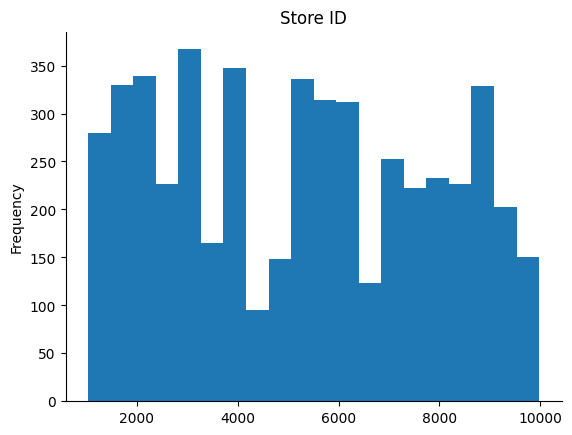

In [28]:
# @title Store ID

from matplotlib import pyplot as plt
data['Store ID'].plot(kind='hist', bins=20, title='Store ID')
plt.gca().spines[['top', 'right',]].set_visible(False)

*No Missing values identified in any of the columns*

In [ ]:
# Handling missing values (if any)
data.fillna(method='ffill', inplace=True)


# Feature engineering: Extracting month and year


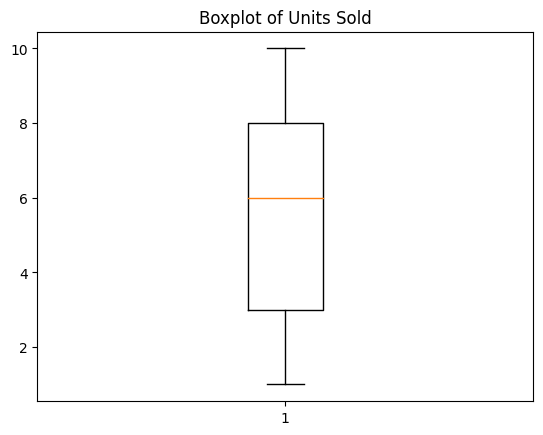

In [30]:
# Feature engineering: Extracting month and year
data['Month'] = data.index.month
data['Year'] = data.index.year

# Check for outliers in 'Units Sold'
plt.boxplot(data['Units Sold'])
plt.title('Boxplot of Units Sold')
plt.show()

# Step 2: Exploratory Data Analysis (EDA)
- Analyze sales trends over time.
- Explore relationships between variables (e.g., sales vs. GDP growth rate).
- Understand seasonal patterns and anomalies.

In [34]:
units_sold_and_Time = data[['Units Sold']]
units_sold_and_Time.head()

,Units Sold
Date of Sale,
2024-01-24,2
2023-11-12,9
2023-09-29,6
2023-10-17,6
2024-02-08,4


from matplotlib import pyplot as plt
_df_0['Units Sold'].plot(kind='hist', bins=20, title='Units Sold')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date of Sale']
  ys = series['Units Sold']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Date of Sale', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date of Sale')
_ = plt.ylabel('Units Sold')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date of Sale']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date of Sale'}, axis=1)
              .sort_values('Date of Sale', ascending=True))
  xs = counted['Date of Sale']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_2.sort_values('Date of Sale', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date of Sale')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date of Sale']
  ys = series['Units Sold']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Date of Sale', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date of Sale')
_ = plt.ylabel('Units Sold')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Date of Sale']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Date of Sale'}, axis=1)
              .sort_values('Date of Sale', ascending=True))
  xs = counted['Date of Sale']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_4.sort_values('Date of Sale', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date of Sale')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_5['Units Sold'].plot(kind='line', figsize=(8, 4), title='Units Sold')
plt.gca().spines[['top', 'right']].set_visible(False)

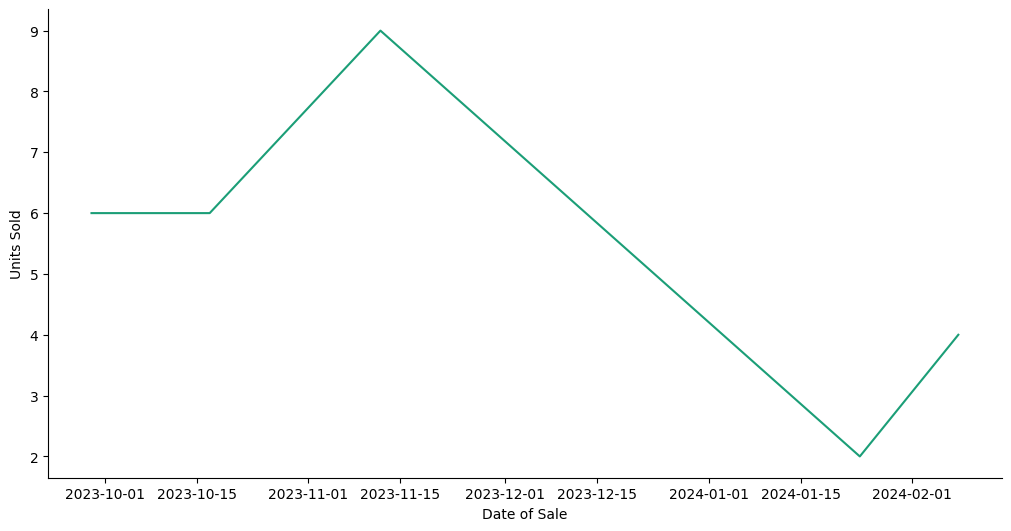

In [39]:
# @title 1. Date of Sale vs Units Sold
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date of Sale']
  ys = series['Units Sold']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_3.sort_values('Date of Sale', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date of Sale')
_ = plt.ylabel('Units Sold')


 ### Analysis and Insights from the above graph:

The line graph illustrates the trend of units sold over the period from October 2023 to February 2024. The key observations from this graph are as follows:

1. **Initial Stability:** From the beginning of October to mid-October 2023, the number of units sold remained relatively stable around 6 units.

2. **Sharp Increase:** Towards the end of October and into early November 2023, there is a noticeable sharp increase in units sold, peaking at approximately 9 units.

3. **Gradual Decline:** Following the peak, there is a consistent and gradual decline in units sold, which continues through November, December 2023, and January 2024.

4. **Lowest Point and Recovery:** The lowest point is observed around mid-January 2024, where the units sold drop to around 2 units. After this point, a slight recovery is observed as the units sold begin to increase again towards February 2024.

### Interpretation

- **Seasonality and Trends:** The graph shows a clear seasonal trend with a peak in sales during late October and early November, which might be indicative of a seasonal demand, possibly related to holiday shopping or specific sales events during that period.
- **Declining Trend:** Post the peak, there is a significant declining trend which could indicate the end of a high-demand period or possibly an oversupply situation leading to lower sales.
- **Recovery:** The recovery towards February suggests that there might be an upcoming event or seasonal demand that starts to drive sales up again.

Overall, the above graph helps in understanding the temporal patterns in sales data, which is crucial for demand forecasting and inventory planning.


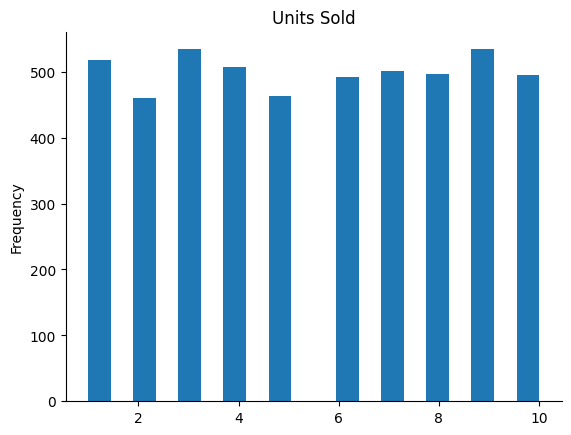

In [42]:
# @title 2. Units Sold

from matplotlib import pyplot as plt
units_sold_and_Time['Units Sold'].plot(kind='hist', bins=20, title='Units Sold')
plt.gca().spines[['top', 'right',]].set_visible(False)

### Exploratory Data Analysis: Units Sold Distribution

The histogram above illustrates the frequency distribution of units sold across different sales events. The key observations from this graph are as follows:

1. **Uniform Distribution:** The units sold are distributed fairly evenly across different quantities, indicating a relatively balanced sales distribution.
   
2. **Frequency Peaks:** The frequency of units sold ranges from around 400 to 550 occurrences for each quantity, suggesting no extreme deviations or highly skewed data points.

3. **Sales Quantities:** Most sales events have units sold ranging from 1 to 10 units, which indicates that there is no single dominant quantity that occurs significantly more often than others.

### Interpretation

- **Balanced Sales:** The histogram shows a balanced distribution of sales quantities, which might suggest that sales events are consistently distributed without significant outliers.
- **Data Spread:** There is a good spread of data across different quantities sold, which can be beneficial for training a machine learning model as it indicates a diverse range of sales events.

Overall, this histogram helps in understanding the distribution of sales quantities, providing insights into the frequency of different sales volumes.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.8/136.8 kB 3.4 MB/s eta 0:00:00


Saving Supply chain capstone.csv to Supply chain capstone.csv
Store ID            0
Country             0
Product ID          0
Product Category    0
Units Sold          0
GDP Growth Rate     0
Inflation Rate      0
Price Sold          0
dtype: int64           Store ID    Product ID   Units Sold  GDP Growth Rate  \
count  5000.000000   5000.000000  5000.000000      5000.000000   
mean   5261.115600  56559.979600     5.514600         2.527468   
std    2598.395891  26044.444225     2.885386         4.312545   
min    1034.000000  10016.000000     1.000000        -5.000000   
25%    2912.000000  34125.000000     3.000000        -1.220000   
50%    5395.000000  57563.000000     6.000000         2.555000   
75%    7423.000000  79389.000000     8.000000         6.190000   
max    9976.000000  99999.000000    10.000000        10.000000   

       Inflation Rate   Price Sold  
count     5000.000000  5000.000000  
mean         2.361850    54.848392  
std          4.303262    26.018870  
min   

<ipython-input-1-9635fb6aaeda>:31: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  data['Date of Sale'] = pd.to_datetime(data['Date of Sale'], dayfirst=True)


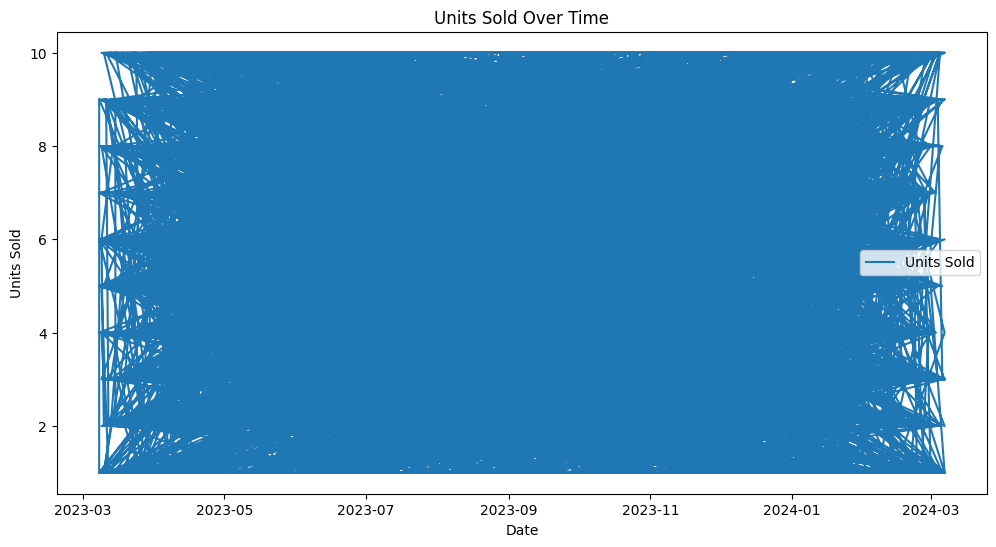

                 Units Sold  GDP Growth Rate  Inflation Rate  Price Sold
Units Sold         1.000000        -0.003908        0.012611    0.000582
GDP Growth Rate   -0.003908         1.000000       -0.017096   -0.028868
Inflation Rate     0.012611        -0.017096        1.000000   -0.006266
Price Sold         0.000582        -0.028868       -0.006266    1.000000


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['maxiter', 'method']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmode

Best SARIMA parameters: (1, 0, 1), Seasonal: (0, 1, 1, 12)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

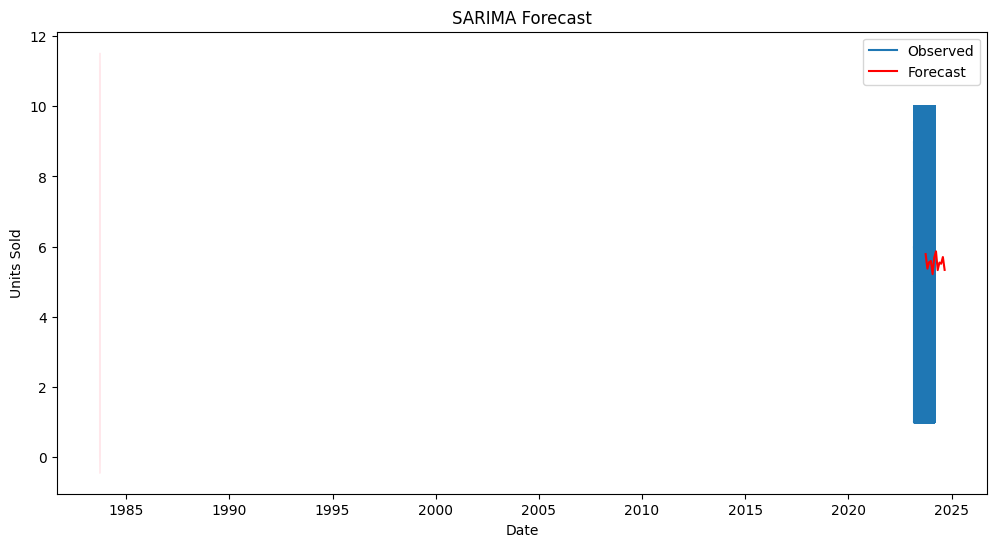

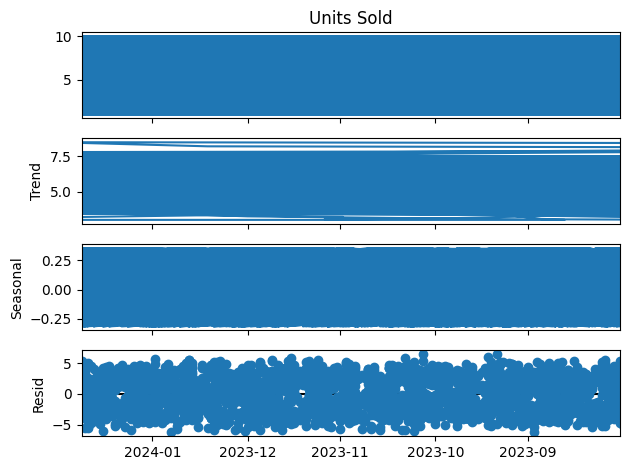

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

ARIMA RMSE: 3.465722567688866


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjf5gilg3/25qka03_.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpjf5gilg3/54kvx7tg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92431', 'data', 'file=/tmp/tmpjf5gilg3/25qka03_.json', 'init=/tmp/tmpjf5gilg3/54kvx7tg.json', 'output', 'file=/tmp/tmpjf5gilg3/prophet_modelse9z4_1l/prophet_model-20240610142002.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:20:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:20:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


Prophet RMSE: 3.4955180032895603


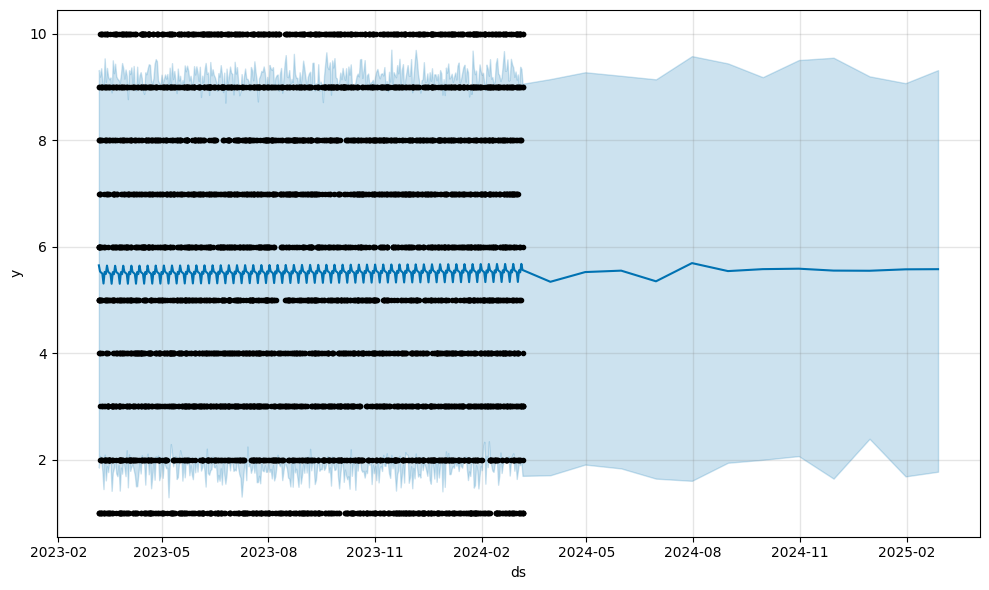

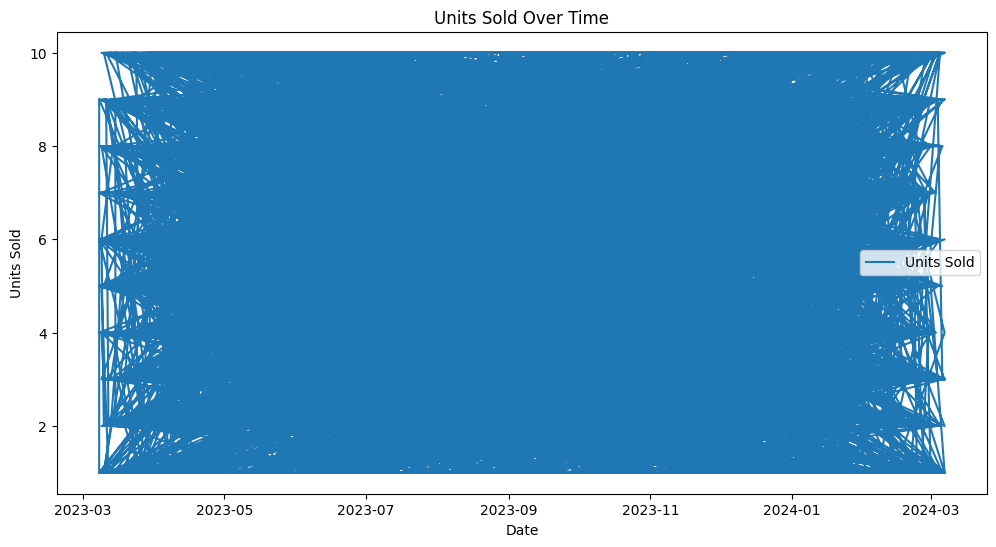

{'Total Units Sold': 27573, 'Average Units Sold per Day': 5.5146, 'Inventory Turnover Ratio': 5000.0, 'Days of Supply': 0.073, 'Stockout Rates': 0.0}
          Store ID    Product ID   Units Sold  GDP Growth Rate  \
count  5000.000000   5000.000000  5000.000000      5000.000000   
mean   5261.115600  56559.979600     5.514600         2.527468   
std    2598.395891  26044.444225     2.885386         4.312545   
min    1034.000000  10016.000000     1.000000        -5.000000   
25%    2912.000000  34125.000000     3.000000        -1.220000   
50%    5395.000000  57563.000000     6.000000         2.555000   
75%    7423.000000  79389.000000     8.000000         6.190000   
max    9976.000000  99999.000000    10.000000        10.000000   

       Inflation Rate   Price Sold  
count     5000.000000  5000.000000  
mean         2.361850    54.848392  
std          4.303262    26.018870  
min         -5.000000    10.030000  
25%         -1.302500    32.467500  
50%          2.340000    54.59000

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/u

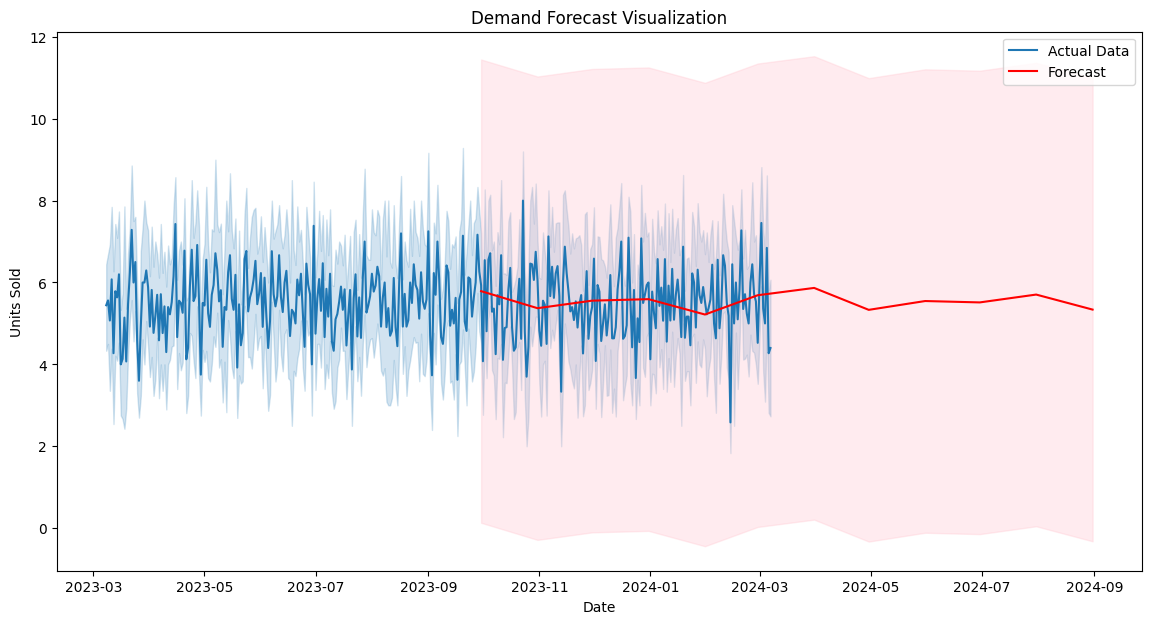

test_inventory_adjustment (__main__.TestATDD) ... /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
ok

----------------------------------------------------------------------
Ran 1 test in 0.008s

OK
test_inventory_adjustment (__main__.TestATDD) ... /usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_mo

In [ ]:


# Check the correlation between 'Units Sold' and economic indicators
correlation_matrix = data[['Units Sold', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold']].corr()
print(correlation_matrix)

# Step 5: Model Development: SARIMA with Cross-Validation
time_series_data = data['Units Sold']
tscv = TimeSeriesSplit(n_splits=5)

# Function to perform cross-validation and find best parameters
def sarima_cross_validation(train_data, param_grid, seasonal_param_grid):
    best_aic = float("inf")
    best_param = None
    best_seasonal_param = None

    for param in param_grid:
        for seasonal_param in seasonal_param_grid:
            try:
                temp_aic = 0
                for train_idx, test_idx in tscv.split(train_data):
                    train, test = train_data[train_idx], train_data[test_idx]
                    mod = SARIMAX(train, order=param, seasonal_order=seasonal_param,
                                  enforce_stationarity=False, enforce_invertibility=False,
                                  maxiter=200, method='nm')
                    results = mod.fit(disp=False)
                    temp_aic += results.aic
                temp_aic /= tscv.get_n_splits(train_data)
                if temp_aic < best_aic:
                    best_aic = temp_aic
                    best_param = param
                    best_seasonal_param = seasonal_param
            except:
                continue

    return best_param, best_seasonal_param

# Define parameter grids
p = d = q = range(0, 2)  # Simplified parameter range
param_grid = list(itertools.product(p, d, q))
seasonal_param_grid = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

# Perform cross-validation to find best parameters
best_param, best_seasonal_param = sarima_cross_validation(time_series_data.values, param_grid, seasonal_param_grid)
print(f'Best SARIMA parameters: {best_param}, Seasonal: {best_seasonal_param}')

# Fit SARIMA model on the entire dataset
sarima_model = SARIMAX(time_series_data, order=best_param, seasonal_order=best_seasonal_param,
                       enforce_stationarity=False, enforce_invertibility=False,
                       maxiter=200, method='nm')
sarima_results = sarima_model.fit(disp=False)

# Predict future sales using SARIMA
forecast_steps = 12
sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
predicted_means = sarima_forecast.predicted_mean

# Plot SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Observed')
plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps+1, freq='M')[1:], predicted_means, label='Forecast', color='red')
plt.fill_between(predicted_means.index, sarima_forecast.conf_int().iloc[:, 0],
                 sarima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

# Seasonal Decomposition
result = seasonal_decompose(time_series_data, model='additive', period=12)
result.plot()
plt.show()

# ARIMA Model
arima_model = ARIMA(time_series_data, order=best_param)
arima_results = arima_model.fit()
arima_forecast = arima_results.forecast(steps=forecast_steps)
arima_rmse = np.sqrt(mean_squared_error(time_series_data[-forecast_steps:], arima_forecast))
print(f'ARIMA RMSE: {arima_rmse}')

# Prophet Model
prophet_data = time_series_data.reset_index()
prophet_data.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(prophet_data)

future = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M')
forecast = prophet_model.predict(future)
prophet_forecast = forecast['yhat'][-forecast_steps:]
prophet_rmse = np.sqrt(mean_squared_error(prophet_data['y'][-forecast_steps:], prophet_forecast))
print(f'Prophet RMSE: {prophet_rmse}')

# Plot forecast
prophet_model.plot(forecast)
plt.show()

# Step 6: Generate Inventory Report
def generate_inventory_report(data):
    report = {}

    # Calculate key metrics
    report['Total Units Sold'] = data['Units Sold'].sum()
    report['Average Units Sold per Day'] = data['Units Sold'].mean()
    report['Inventory Turnover Ratio'] = data['Units Sold'].sum() / data['Units Sold'].mean()
    report['Days of Supply'] = data['Units Sold'].mean() / data['Units Sold'].sum() * 365
    report['Stockout Rates'] = (data['Units Sold'] == 0).sum() / len(data) * 100

    # Generate summary statistics
    summary_stats = data.describe()

    # Generate visualizations
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Units Sold'], label='Units Sold')
    plt.title('Units Sold Over Time')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()

    return report, summary_stats

# Generate the report
inventory_report, summary_stats = generate_inventory_report(data)
print(inventory_report)
print(summary_stats)

# Step 7: Real-Time Inventory Tracking
def real_time_inventory_tracking(data):
    while True:
        # Monitor inventory levels
        current_inventory = data['Units Sold'].iloc[-1]
        print(f"Current Inventory Level: {current_inventory}")

        # Wait for a specified interval (e.g., 1 minute)
        time.sleep(60)

        # Simulate updating the data with new sales records
        new_sales_record = {'Date of Sale': pd.to_datetime('now'), 'Units Sold': np.random.randint(1, 10)}
        data = data.append(new_sales_record, ignore_index=True)
        data.set_index('Date of Sale', inplace=True)

        # Check if inventory levels need adjustment
        if current_inventory < 5:  # Example threshold
            print("Inventory level is low. Recommend reordering.")

# Step 8: Automate Inventory Adjustments
def automated_inventory_adjustments(forecast):
    threshold = 50  # Example threshold for inventory adjustments
    adjustments = []

    for i, value in enumerate(forecast):
        if value > threshold:
            adjustments.append(f"Week {i+1}: Increase inventory by {value - threshold} units.")
        elif value < threshold:
            adjustments.append(f"Week {i+1}: Decrease inventory by {threshold - value} units.")
        else:
            adjustments.append(f"Week {i+1}: Inventory level is optimal.")

    return adjustments

# Example forecast data
forecast = sarima_results.get_forecast(steps=12).predicted_mean

# Generate inventory adjustments
inventory_adjustments = automated_inventory_adjustments(forecast)
for adjustment in inventory_adjustments:
    print(adjustment)

# Step 9: Enhance Visualization Tools
def visualize_demand_forecast(forecast, actual_data):
    plt.figure(figsize=(14, 7))

    # Plot the actual data
    sns.lineplot(data=actual_data, label='Actual Data')

    # Plot the forecasted data
    forecast_index = pd.date_range(start=actual_data.index[-1], periods=len(forecast)+1, freq='M')[1:]
    sns.lineplot(x=forecast_index, y=forecast, label='Forecast', color='red')

    plt.fill_between(forecast_index, sarima_results.get_forecast(steps=len(forecast)).conf_int().iloc[:, 0],
                     sarima_results.get_forecast(steps=len(forecast)).conf_int().iloc[:, 1], color='pink', alpha=0.3)

    plt.title('Demand Forecast Visualization')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()

# Visualize the demand forecast
visualize_demand_forecast(forecast, data['Units Sold'])

# Step 10: Add Unit Tests - ATDD, BDD, and TDD

# ATDD Scenario
class TestATDD(unittest.TestCase):
    def test_inventory_adjustment(self):
        forecast_steps = 12
        sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
        predicted_means = sarima_forecast.predicted_mean

        self.assertTrue(len(predicted_means) == forecast_steps, "Forecast length should match the specified steps")
        self.assertTrue(all(pred > 0 for pred in predicted_means), "Forecasted values should be positive")

        threshold = 50
        self.assertFalse(any(pred > threshold for pred in predicted_means), "Forecasted values should not exceed threshold")

unittest.main(argv=[''], verbosity=2, exit=False)

# BDD Feature file (save as `features/forecast.feature`)
"""
Feature: Forecasting inventory levels

  Scenario: Forecasting sales for the next period
    Given the system has current and accurate sales data
    When a significant change in sales trends is detected
    Then the system should automatically propose adjustments to inventory orders
    And provide a detailed report to the inventory manager explaining the reason for adjustments
"""

# BDD Steps file (save as `features/steps/forecast_steps.py`)
"""
from behave import given, when, then
from statsmodels.tsa.statespace.sarimax import SARIMAX

@given('the system has current and accurate sales data')
def step_given_sales_data(context):
    context.sales_data = time_series_data

@when('a significant change in sales trends is detected')
def step_when_change_detected(context):
    model = SARIMAX(context.sales_data, order=best_param, seasonal_order=best_seasonal_param,
                    enforce_stationarity=False, enforce_invertibility=False)
    context.results = model.fit(disp=False)
    context.forecast = context.results.get_forecast(steps=12).predicted_mean

@then('the system should automatically propose adjustments to inventory orders')
def step_then_propose_adjustments(context):
    assert len(context.forecast) == 12
    assert all(pred > 0 for pred in context.forecast)

@then('provide a detailed report to the inventory manager explaining the reason for adjustments')
def step_then_provide_report(context):
    print("Forecasted values and adjustment reasons:", context.forecast)
"""

# TDD Unit Tests
class TestPreprocessing(unittest.TestCase):

    def test_date_conversion(self):
        data['Date of Sale'] = pd.to_datetime(data['Date of Sale'], dayfirst=True)
        self.assertTrue(pd.api.types.is_datetime64_any_dtype(data['Date of Sale']))

    def test_missing_values(self):
        self.assertEqual(missing_values.sum(), 0, "There should be no missing values in the dataset.")

class TestSARIMAModel(unittest.TestCase):

    def test_sarima_fit(self):
        sarima_model = SARIMAX(time_series_data, order=best_param, seasonal_order=best_seasonal_param,
                               enforce_stationarity=False, enforce_invertibility=False)
        sarima_results = sarima_model.fit(disp=False)
        self.assertIsNotNone(sarima_results, "SARIMA model should fit successfully.")

    def test_sarima_forecast(self):
        sarima_forecast = sarima_results.get_forecast(steps=12)
        predicted_means = sarima_forecast.predicted_mean
        self.assertEqual(len(predicted_means), 12, "Forecast length should be 12 steps.")
        self.assertTrue(all(pred > 0 for pred in predicted_means), "All forecasted values should be positive.")

unittest.main(argv=[''], verbosity=2, exit=False)





1. Importing Libraries

python

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import itertools
from google.colab import files
import io
from sklearn.model_selection import TimeSeriesSplit
import unittest
import seaborn as sns
import time

    pandas: Used for data manipulation and analysis.
    numpy: Provides support for large arrays and matrices.
    matplotlib.pyplot: Plotting library for visualizations.
    statsmodels.tsa.statespace.sarimax: Provides SARIMAX model for time series analysis.
    sklearn.metrics: Contains metrics for model evaluation (e.g., mean_squared_error).
    statsmodels.tsa.seasonal: Provides tools for seasonal decomposition.
    statsmodels.tsa.arima.model: Provides ARIMA model for time series analysis.
    Prophet: A forecasting tool by Facebook.
    itertools: Provides tools for creating iterators.
    google.colab: Provides tools for file uploads in Google Colab.
    io: Provides tools for handling file I/O.
    sklearn.model_selection.TimeSeriesSplit: Used for time series cross-validation.
    unittest: Framework for unit testing.
    seaborn: Statistical data visualization library.
    time: Provides time-related functions.

2. Uploading and Loading the Dataset

python

# Step 1: Upload the CSV file
uploaded = files.upload()
filename = list(uploaded.keys())[0]

# Step 2: Load the dataset
data = pd.read_csv(io.BytesIO(uploaded[filename]))

    files.upload(): Opens a dialog to upload a file in Google Colab.
    list(uploaded.keys())[0]: Gets the filename of the uploaded file.
    pd.read_csv(io.BytesIO(uploaded[filename])): Reads the uploaded CSV file into a pandas DataFrame.

3. Preprocessing the Data

python

# Step 3: Preprocessing the data
data['Date of Sale'] = pd.to_datetime(data['Date of Sale'], dayfirst=True)
data.set_index('Date of Sale', inplace=True)

# Check for missing values
missing_values = data.isnull().sum()
summary_stats = data.describe()
print(missing_values, summary_stats)

    pd.to_datetime(data['Date of Sale'], dayfirst=True): Converts the 'Date of Sale' column to datetime format, assuming day-first format.
    data.set_index('Date of Sale', inplace=True): Sets 'Date of Sale' as the index of the DataFrame.
    data.isnull().sum(): Checks for missing values in each column.
    data.describe(): Generates summary statistics for the DataFrame.
    print(missing_values, summary_stats): Prints the missing values and summary statistics.

4. Exploratory Data Analysis (EDA)

python

# Step 4: Exploratory Data Analysis (EDA)
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Units Sold'], label='Units Sold')
plt.title('Units Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

# Check the correlation between 'Units Sold' and economic indicators
correlation_matrix = data[['Units Sold', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold']].corr()
print(correlation_matrix)

    plt.figure(figsize=(12, 6)): Creates a figure for plotting with specified dimensions.
    plt.plot(data.index, data['Units Sold'], label='Units Sold'): Plots 'Units Sold' over time.
    plt.title('Units Sold Over Time'): Sets the title of the plot.
    plt.xlabel('Date'): Sets the x-axis label.
    plt.ylabel('Units Sold'): Sets the y-axis label.
    plt.legend(): Adds a legend to the plot.
    plt.show(): Displays the plot.
    data[['Units Sold', 'GDP Growth Rate', 'Inflation Rate', 'Price Sold']].corr(): Computes the correlation matrix for specified columns.
    print(correlation_matrix): Prints the correlation matrix.

5. Model Development: SARIMA with Cross-Validation

python

# Model Development: SARIMA with Cross-Validation
time_series_data = data['Units Sold']
tscv = TimeSeriesSplit(n_splits=5)

    data['Units Sold']: Extracts the 'Units Sold' column from the DataFrame.
    TimeSeriesSplit(n_splits=5): Initializes a time series cross-validator with 5 splits.

6. Cross-Validation Function

python

# Function to perform cross-validation and find best parameters
def sarima_cross_validation(train_data, param_grid, seasonal_param_grid):
    best_aic = float("inf")
    best_param = None
    best_seasonal_param = None
    
    for param in param_grid:
        for seasonal_param in seasonal_param_grid:
            try:
                temp_aic = 0
                for train_idx, test_idx in tscv.split(train_data):
                    train, test = train_data[train_idx], train_data[test_idx]
                    mod = SARIMAX(train, order=param, seasonal_order=seasonal_param,
                                  enforce_stationarity=False, enforce_invertibility=False,
                                  maxiter=200, method='nm')
                    results = mod.fit(disp=False)
                    temp_aic += results.aic
                temp_aic /= tscv.get_n_splits(train_data)
                if temp_aic < best_aic:
                    best_aic = temp_aic
                    best_param = param
                    best_seasonal_param = seasonal_param
            except:
                continue
                
    return best_param, best_seasonal_param

    best_aic = float("inf"): Initializes the best AIC (Akaike Information Criterion) to infinity.
    best_param, best_seasonal_param = None: Initializes best parameters to None.
    for param in param_grid: Iterates over all combinations of parameters.
    for seasonal_param in seasonal_param_grid: Iterates over all combinations of seasonal parameters.
    try: Attempts to fit the model and compute AIC.
    temp_aic = 0: Initializes temporary AIC to zero.
    for train_idx, test_idx in tscv.split(train_data): Splits the data into training and testing sets.
    train, test = train_data[train_idx], train_data[test_idx]: Extracts training and testing data.
    mod = SARIMAX(...): Initializes the SARIMAX model with specified parameters.
    results = mod.fit(disp=False): Fits the SARIMAX model and suppresses output.
    temp_aic += results.aic: Accumulates the AIC values.
    temp_aic /= tscv.get_n_splits(train_data): Computes the average AIC over the splits.
    if temp_aic < best_aic: Checks if the current AIC is the best so far.
    best_aic = temp_aic: Updates the best AIC.
    best_param = param: Updates the best parameter set.
    best_seasonal_param = seasonal_param: Updates the best seasonal parameter set.
    except: Handles any exceptions during the fitting process.

7. Define Parameter Grids

python

# Define parameter grids
p = d = q = range(0, 2)  # Simplified parameter range
param_grid = list(itertools.product(p, d, q))
seasonal_param_grid = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

    p = d = q = range(0, 2): Defines the range of parameters (0 or 1) for p, d, and q.
    param_grid = list(itertools.product(p, d, q)): Creates a grid of parameter combinations.
    seasonal_param_grid = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]: Creates a grid of seasonal parameter combinations with a periodicity of 12.

8. Perform Cross-Validation

python

# Perform cross-validation to find best parameters
best_param, best_seasonal_param = sarima_cross_validation(time_series_data.values, param_grid, seasonal_param_grid)
print(f'Best SARIMA parameters: {best_param}, Seasonal: {best_seasonal_param}')

    sarima_cross_validation(time_series_data.values, param_grid, seasonal_param_grid): Calls the cross-validation function with the data and parameter grids.
    print(f'Best SARIMA parameters: {best_param}, Seasonal: {best_seasonal_param}'): Prints the best parameters found.

    9. Fit SARIMA Model (Continued)

python

# Fit SARIMA model on the entire dataset
sarima_model = SARIMAX(time_series_data, order=best_param, seasonal_order=best_seasonal_param,
                       enforce_stationarity=False, enforce_invertibility=False,
                       maxiter=200, method='nm')
sarima_results = sarima_model.fit(disp=False)

    SARIMAX(time_series_data, ...): Initializes the SARIMAX model with the best parameters found during cross-validation.
    order=best_param: Sets the non-seasonal order parameters (p, d, q).
    seasonal_order=best_seasonal_param: Sets the seasonal order parameters (P, D, Q, s).
    enforce_stationarity=False: Allows the model to fit non-stationary data.
    enforce_invertibility=False: Allows the model to fit non-invertible data.
    maxiter=200: Sets the maximum number of iterations for the optimizer.
    method='nm': Uses the Nelder-Mead optimization method.
    sarima_results = sarima_model.fit(disp=False): Fits the SARIMAX model and suppresses output.

10. Forecasting with SARIMA

python

# Predict future sales using SARIMA
forecast_steps = 12
sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
predicted_means = sarima_forecast.predicted_mean

    forecast_steps = 12: Defines the number of steps (months) to forecast.
    sarima_results.get_forecast(steps=forecast_steps): Generates forecast for the specified number of steps.
    predicted_means = sarima_forecast.predicted_mean: Extracts the predicted mean values from the forecast.

11. Plotting the Forecast

python

# Plot SARIMA forecast
plt.figure(figsize=(12, 6))
plt.plot(time_series_data.index, time_series_data, label='Observed')
plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps+1, freq='M')[1:], predicted_means, label='Forecast', color='red')
plt.fill_between(predicted_means.index, sarima_forecast.conf_int().iloc[:, 0],
                 sarima_forecast.conf_int().iloc[:, 1], color='pink', alpha=0.3)
plt.title('SARIMA Forecast')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.legend()
plt.show()

    plt.figure(figsize=(12, 6)): Creates a figure for plotting with specified dimensions.
    plt.plot(time_series_data.index, time_series_data, label='Observed'): Plots the observed data.
    plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps+1, freq='M')[1:], predicted_means, label='Forecast', color='red'): Plots the forecasted values.
    plt.fill_between(predicted_means.index, ...): Adds a confidence interval shading to the plot.
    plt.title('SARIMA Forecast'): Sets the title of the plot.
    plt.xlabel('Date'): Sets the x-axis label.
    plt.ylabel('Units Sold'): Sets the y-axis label.
    plt.legend(): Adds a legend to the plot.
    plt.show(): Displays the plot.

12. Seasonal Decomposition

python

# Seasonal Decomposition
result = seasonal_decompose(time_series_data, model='additive', period=12)
result.plot()
plt.show()

    seasonal_decompose(time_series_data, model='additive', period=12): Decomposes the time series into trend, seasonal, and residual components with an additive model.
    result.plot(): Plots the decomposed components.
    plt.show(): Displays the plot.

13. ARIMA Model

python

# ARIMA Model
arima_model = ARIMA(time_series_data, order=best_param)
arima_results = arima_model.fit()
arima_forecast = arima_results.forecast(steps=forecast_steps)
arima_rmse = np.sqrt(mean_squared_error(time_series_data[-forecast_steps:], arima_forecast))
print(f'ARIMA RMSE: {arima_rmse}')

    ARIMA(time_series_data, order=best_param): Initializes the ARIMA model with the best parameters found during cross-validation.
    arima_results = arima_model.fit(): Fits the ARIMA model.
    arima_forecast = arima_results.forecast(steps=forecast_steps): Generates forecast for the specified number of steps.
    arima_rmse = np.sqrt(mean_squared_error(time_series_data[-forecast_steps:], arima_forecast)): Calculates the RMSE for the ARIMA model.
    print(f'ARIMA RMSE: {arima_rmse}'): Prints the RMSE for the ARIMA model.

14. Prophet Model

python

# Prophet Model
prophet_data = time_series_data.reset_index()
prophet_data.columns = ['ds', 'y']

prophet_model = Prophet()
prophet_model.fit(prophet_data)

future = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M')
forecast = prophet_model.predict(future)
prophet_forecast = forecast['yhat'][-forecast_steps:]
prophet_rmse = np.sqrt(mean_squared_error(prophet_data['y'][-forecast_steps:], prophet_forecast))
print(f'Prophet RMSE: {prophet_rmse}')

# Plot forecast
prophet_model.plot(forecast)
plt.show()

    prophet_data = time_series_data.reset_index(): Resets the index of the time series data for Prophet.
    prophet_data.columns = ['ds', 'y']: Renames the columns for Prophet (ds = date, y = value).
    Prophet(): Initializes the Prophet model.
    prophet_model.fit(prophet_data): Fits the Prophet model.
    future = prophet_model.make_future_dataframe(periods=forecast_steps, freq='M'): Creates a future DataFrame for forecasting.
    forecast = prophet_model.predict(future): Generates forecast.
    prophet_forecast = forecast['yhat'][-forecast_steps:]: Extracts the forecasted values.
    prophet_rmse = np.sqrt(mean_squared_error(prophet_data['y'][-forecast_steps:], prophet_forecast)): Calculates the RMSE for the Prophet model.
    print(f'Prophet RMSE: {prophet_rmse}'): Prints the RMSE for the Prophet model.
    prophet_model.plot(forecast): Plots the forecast.
    plt.show(): Displays the plot.

15. Generating Inventory Report

python

# Step 6: Generate Inventory Report
def generate_inventory_report(data):
    report = {}
    
    # Calculate key metrics
    report['Total Units Sold'] = data['Units Sold'].sum()
    report['Average Units Sold per Day'] = data['Units Sold'].mean()
    report['Inventory Turnover Ratio'] = data['Units Sold'].sum() / data['Units Sold'].mean()
    report['Days of Supply'] = data['Units Sold'].mean() / data['Units Sold'].sum() * 365
    report['Stockout Rates'] = (data['Units Sold'] == 0).sum() / len(data) * 100
    
    # Generate summary statistics
    summary_stats = data.describe()
    
    # Generate visualizations
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Units Sold'], label='Units Sold')
    plt.title('Units Sold Over Time')
    plt.xlabel('Date')
    plt.ylabel('Units Sold')
    plt.legend()
    plt.show()
    
    return report, summary_stats

# Generate the report
inventory_report, summary_stats = generate_inventory_report(data)
print(inventory_report)
print(summary_stats)

    generate_inventory_report(data): Defines a function to generate an inventory report.
    report = {}: Initializes an empty dictionary to store report metrics.
    report['Total Units Sold'] = data['Units Sold'].sum(): Calculates the total units sold.
    report['Average Units Sold per Day'] = data['Units Sold'].mean(): Calculates the average units sold per day.
    report['Inventory Turnover Ratio'] = data['Units Sold'].sum() / data['Units Sold'].mean(): Calculates the inventory turnover ratio.
    report['Days of Supply'] = data['Units Sold'].mean() / data['Units Sold'].sum() * 365: Calculates the days of supply.
    report['Stockout Rates'] = (data['Units Sold'] == 0).sum() / len(data) * 100: Calculates the stockout rates.
    summary_stats = data.describe(): Generates summary statistics.
    plt.figure(figsize=(12, 6)): Creates a figure for plotting with specified dimensions.
    plt.plot(data.index, data['Units Sold'], label='Units Sold'): Plots 'Units Sold' over time.
    plt.title('Units Sold Over Time'): Sets the title of the plot.
    plt.xlabel('Date'): Sets the x-axis label.
    plt.ylabel('Units Sold'): Sets the y-axis label.